# Models traning on RPW Dataset

This notebook train and compare the performance of MobileNetV3, EfficientNetB0, EfficientNetB2, EfficientNetB3 and EfficientNetB4 models on a custome Red Palm Wheevil dataset for classification task.

## Overview
- We'll use transfer learning with pre-trained models
- The models will be partially frozen to preserve low-level features
- Custom classifiers will be added to adapt to our binary classification task
- Performance metrics will be evaluated and visualized

## 1- Setting Up the Environment

First, let's import all necessary libraries and set up our device configuration.

In [ ]:
import os
import glob
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torchvision.models import (
    mobilenet_v3_large,
    MobileNet_V3_Large_Weights,
    efficientnet_b0,
    EfficientNet_B0_Weights,
    efficientnet_b2,
    EfficientNet_B2_Weights,
    efficientnet_b3,
    EfficientNet_B3_Weights,
    efficientnet_b4,
    EfficientNet_B4_Weights,
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
from torch.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Metal (MPS)")
else:
    device = torch.device("cpu")
    print("Using CPU")

use_amp = device.type == "cuda"
scaler = GradScaler(device="cuda", enabled=use_amp)

Using GPU: Tesla T4


In [ ]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4


Seting up a seed for reproduceability

In [ ]:
seed = 7
# Set seed for reproducibility
torch.manual_seed(seed)

Configuring the models to be used

In [62]:
MODEL_CONFIGS = {
    "mobilenet": {
        "builder": mobilenet_v3_large,
        "weights": MobileNet_V3_Large_Weights.DEFAULT,
        "classifier_index": 0,
        "input_size": 224,
    },
    "efficientnet_b0": {
        "builder": efficientnet_b0,
        "weights": EfficientNet_B0_Weights.DEFAULT,
        "classifier_index": 1,
        "input_size": 224,
    },
     "efficientnet_b2": {
        "builder": efficientnet_b2,
        "weights": EfficientNet_B2_Weights.DEFAULT,
        "classifier_index": 1,
        "input_size": 260,
    },
      "efficientnet_b3": {
        "builder": efficientnet_b3,
        "weights": EfficientNet_B3_Weights.DEFAULT,
        "classifier_index": 1,
        "input_size": 300,
    },
    "efficientnet_b4": {
        "builder": efficientnet_b4,
        "weights": EfficientNet_B4_Weights.DEFAULT,
        "classifier_index": 1,
        "input_size": 380,
    }
}

## 2- Dataset Implementation

Our `InMemoryDataset` class loads all images into RAM at initialization. This approach trades memory for speed, which is beneficial for smaller datasets as it eliminates disk I/O during training.

In [ ]:
class InMemoryDataset(Dataset):
    """
    A custom dataset class that loads images and their corresponding labels into memory.

    Args:
        root_dir (str): The root directory where the image folders are located.
        transform (callable, optional): A function/transform to apply to the images (default is None).

    Attributes:
        data (list): A list of transformed images.
        labels (list): A list of corresponding labels for each image.
        class_to_idx (dict): A dictionary mapping class names to numeric labels.

    Methods:
        __len__(): Returns the number of samples in the dataset.
        __getitem__(idx): Returns the image and its label at the specified index.
    """

    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []

        class_dirs = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_dirs)}

        for cls_name in class_dirs:
            cls_path = os.path.join(root_dir, cls_name)
            img_paths = glob.glob(os.path.join(cls_path, "*.*"))
            for path in img_paths:
                try:
                    img = Image.open(path).convert("RGB")
                    if self.transform:
                        img = self.transform(img)
                    self.data.append(img)
                    self.labels.append(self.class_to_idx[cls_name])
                except Exception as e:
                    print(f"Skipping image {path}: {e}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

## 3- Model Building Functions

We'll define functions for:
1. Partial freezing of model layers to leverage pre-trained weights
2. Building the model architecture with custom classifier heads

### Function for partial layer freezing

In [ ]:
def freeze_partial(model, freeze_ratio=0.6):
    """
    Freezes a proportion of the early layers of a model.

    Args:
        model (nn.Module): The model whose layers will be partially frozen.
        freeze_ratio (float, optional): The ratio of early layers to freeze.
                                        Default is 0.6 (60% of layers will be frozen).

    Modifies the model in place by setting the `requires_grad` attribute to False
    for the parameters of the frozen layers, preventing them from being updated during training.
    """
    # Get all layers of the model's features (assuming 'features' attribute is used)
    layers = list(model.features.children())

    # Calculate how many layers to freeze
    num_freeze = int(len(layers) * freeze_ratio)

    # Freeze the specified number of layers
    for i, layer in enumerate(layers):
        if i < num_freeze:
            for param in layer.parameters():
                param.requires_grad = False

### Function for bulding the model

In [ ]:
def build_model(model_name, num_classes=2, freeze_ratio=0.6):
    """
    Builds and returns a model based on the specified configuration.

    Args:
        model_name (str): The name of the model to build (e.g., 'resnet', 'vgg').
        num_classes (int, optional): The number of output classes for classification. Default is 2.
        freeze_ratio (float, optional): The ratio of layers to freeze. Default is 0.6 (60% of layers will be frozen).

    Returns:
        nn.Module: The modified model ready for training, with the specified number of output classes and frozen layers.

    Raises:
        ValueError: If the provided model_name is not supported.

    Modifications:
        - The model's classifier is updated to have a 512-unit hidden layer with ReLU activation and dropout.
        - A portion of the model's layers (defined by freeze_ratio) are frozen to prevent weight updates during training.
    """
    # Check if the model name is valid
    if model_name not in MODEL_CONFIGS:
        raise ValueError(f"Unsupported model name: {model_name}")

    # Retrieve model configuration
    config = MODEL_CONFIGS[model_name]

    # Build the model with the corresponding weights
    model = config["builder"](weights=config["weights"])
    print(model.classifier)

    # Update the classifier layer
    in_features = model.classifier[config["classifier_index"]].in_features
    model.classifier = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes),
    )

    # Freeze early layers
    freeze_partial(model, freeze_ratio)

    return model.to(device)

## 4- Training and Evaluation Functions

Next, we'll define functions for:
1. Training the models with early stopping
2. Evaluating model performance with multiple metrics
3. Visualizing the training process and results

### Main function for training

In [ ]:
from tqdm import tqdm

# Function to move the images and labels (if provided) to the specified device (CPU or CUDA)
def transfer_to_device(imgs, labels=None):
    """
    Transfers images and optional labels to the specified device (CPU or CUDA).

    Args:
        imgs (Tensor): The image batch to transfer to the device.
        labels (Tensor, optional): The corresponding labels to transfer. Default is None.

    Returns:
        Tuple: A tuple containing the transferred images and labels (if provided).
            - If `labels` is provided, returns (imgs, labels).
            - If `labels` is not provided, returns only imgs.

    This function utilizes the `non_blocking` argument for CUDA to speed up data transfer.
    """
    # Transfer images to the specified device
    imgs = imgs.to(device, non_blocking=(device.type == "cuda"))

    if labels is not None:
        # Transfer labels to the specified device, if provided
        labels = labels.to(device, non_blocking=(device.type == "cuda"))
        return imgs, labels

    return imgs

In [ ]:
import copy
def train_model(model, train_loader, val_loader, model_name, epochs=10, patience=3, base_save_dir="/content/drive/MyDrive/saved_models_states"):
    """
    Trains the model with early stopping and saves the best version based on validation loss.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): Training data.
        val_loader (DataLoader): Validation data.
        model_name (str): Used to dynamically name the saved model.
        epochs (int): Total number of training epochs.
        patience (int): Early stopping patience.
        base_save_dir (str): Directory to save best model.

    Returns:
        Tuple: (train_loss_hist, val_loss_hist, best_model_path)
    """
    os.makedirs(base_save_dir, exist_ok=True)
    save_path = os.path.join(base_save_dir, f"{model_name}_best_model.pth")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)
    scaler = GradScaler(enabled=(device.type == "cuda"))

    best_val_loss = float("inf")
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    train_loss_hist, val_loss_hist = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            imgs, labels = transfer_to_device(imgs, labels)
            optimizer.zero_grad()

            with autocast(device_type=device.type, enabled=(device.type == "cuda")):
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            if device.type == "cuda":
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                imgs, labels = transfer_to_device(imgs, labels)

                with autocast(device_type=device.type, enabled=(device.type == "cuda")):
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)

                total_val_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        train_loss_hist.append(avg_train_loss)
        val_loss_hist.append(avg_val_loss)

        print(f"[Epoch {epoch+1}] 🔹 Train Loss: {avg_train_loss:.4f} 🔸 Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)
            print(f"✅ Best model saved at epoch {epoch+1} to {save_path}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"⏳ No improvement for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"⛔ Early stopping triggered after {epoch+1} epochs.")
            break

    return train_loss_hist, val_loss_hist, save_path

### Evaluation function

In [ ]:
def evaluate(model, test_loader, class_names=None, show_cm=True):
    """
    Evaluates the model's performance on the test set.

    Args:
        model (nn.Module): The trained model to be evaluated.
        test_loader (DataLoader): DataLoader for the test dataset.
        class_names (list, optional): A list of class names for the target labels.
                                       If None, will infer from the dataset.
        show_cm (bool, optional): If True, displays a confusion matrix plot. Default is True.

    Returns:
        Tuple: A tuple containing the following evaluation metrics:
            - accuracy (float): The accuracy of the model on the test set.
            - precision (float): The precision of the model on the test set.
            - recall (float): The recall of the model on the test set.
            - f1 (float): The F1 score of the model on the test set.

    This function computes and prints:
        - Accuracy, Precision, Recall, and F1 Score
        - A classification report
        - Optionally, a confusion matrix
    """
    model.eval()  # Set the model to evaluation mode
    all_preds, all_labels = [], []

    with torch.no_grad():  # Disable gradient computation during evaluation
        for imgs, labels in test_loader:
            imgs = imgs.to(device, non_blocking=(device.type == "cuda"))
            labels = labels.to(device, non_blocking=(device.type == "cuda"))

            outputs = model(imgs)
            preds = (
                torch.argmax(outputs, dim=1).cpu().numpy()
            )  # Get the predicted class
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())  # Collect all labels

    # Infer class names if not provided
    if (
        class_names is None
        and hasattr(test_loader.dataset, "dataset")
        and hasattr(test_loader.dataset.dataset, "classes")
    ):
        class_names = test_loader.dataset.dataset.classes

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    # Print the evaluation metrics
    print(f"\nEvaluation Metrics:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

    # Print the classification report
    print("\nClassification Report:")
    print(
        classification_report(
            all_labels, all_preds, target_names=class_names, zero_division=0
        )
    )

    # Confusion matrix
    if show_cm:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
        )
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()

    return acc, prec, rec, f1

### Function to plot the loss

In [ ]:
def plot_loss(train_loss, val_loss, title):
    """
    Plots the training and validation loss curves over epochs.

    Args:
        train_loss (list): A list of training loss values, one for each epoch.
        val_loss (list): A list of validation loss values, one for each epoch.
        title (str): The title of the plot.

    Displays:
        A plot with training and validation loss curves, showing how the losses change over epochs.
    """
    plt.figure(figsize=(10, 6))  # Set figure size
    plt.plot(train_loss, label="Train Loss", color="blue")  # Plot training loss
    plt.plot(val_loss, label="Val Loss", color="red")  # Plot validation loss
    plt.title(title)  # Set the plot title
    plt.xlabel("Epoch")  # X-axis label
    plt.ylabel("Loss")  # Y-axis label
    plt.legend()  # Show legend
    plt.grid(True)  # Show gridlines for better readability
    plt.show()  # Display the plot

## 5- Data Preparation

Let's set up our data transformations and loading function.

In [37]:
from torch.utils.data import Subset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r /content/drive/MyDrive/data.zip /content/
!unzip -q data.zip

In [64]:
def prepare_dataloaders(
    model_name, data_path="/content/data", batch_size=32, seed=seed, sample_size=None
):
    """
    Prepares the training, validation, and test data loaders from a given dataset.

    Args:
        model_name (str): The model name, used to retrieve the input image size from MODEL_CONFIGS.
        data_path (str, optional): The path to the dataset. Default is "./data".
        batch_size (int, optional): The batch size for the DataLoader. Default is 32.
        seed (int, optional): The seed for random splitting the dataset. Default is None.
        sample_size (int, optional): The number of samples to use for the dataset. If None, the full dataset is used. Default is None.

    Returns:
        tuple: A tuple containing the following elements:
            - train_loader (DataLoader): The data loader for the training dataset.
            - val_loader (DataLoader): The data loader for the validation dataset.
            - test_loader (DataLoader): The data loader for the test dataset.
            - class_names (list): A list of class names in the dataset.

    This function performs the following:
        - Applies image transformations (resize, normalization) to the dataset.
        - Optionally creates a subset of the dataset based on the sample_size.
        - Splits the dataset into training, validation, and test subsets.
        - Creates DataLoader instances for each subset.
        - Prints dataset size information and class names.
    """
    img_size = MODEL_CONFIGS[model_name]["input_size"]

    # Image preprocessing pipeline
    common_transforms = transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    # Load dataset using ImageFolder
    full_dataset = datasets.ImageFolder(root=data_path, transform=common_transforms)
    # Save class names before creating the subset
    class_names = full_dataset.classes

    # Create a subset of the dataset (if sample_size is specified)
    if sample_size:
        # Randomly sample 'sample_size' number of images from the dataset
        indices = torch.randperm(len(full_dataset)).tolist()[:sample_size]
        full_dataset = Subset(full_dataset, indices)

    # Dataset split (70% training, 15% validation, 15% test)
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    # Ensure reproducibility by using the provided seed
    generator = torch.Generator().manual_seed(seed)
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size], generator=generator
    )

    # Create DataLoader instances for each dataset split
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


    # Info on dataset sizes and class names
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
    print(f"Classes: {class_names}")

    return train_loader, val_loader, test_loader, class_names

## 6- Models

### 1.Train and Evaluate MobileNetV3

Now let's train our first model, MobileNetV3, and evaluate its performance.

In [35]:
model_name = "mobilenet"

# Prepare data
train_loader, val_loader, test_loader, class_names = prepare_dataloaders(model_name, batch_size=64)

# Build model
mobilenet_model = build_model(model_name)
print("Using device:", device)
print("Model on device:", next(mobilenet_model.parameters()).device)

Train dataset size: 9800
Validation dataset size: 2100
Test dataset size: 2100
Classes: ['NRPW', 'RPW']
Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=1000, bias=True)
)
Using device: cuda
Model on device: cuda:0



===== Training MobileNetV3 with Early Stopping =====


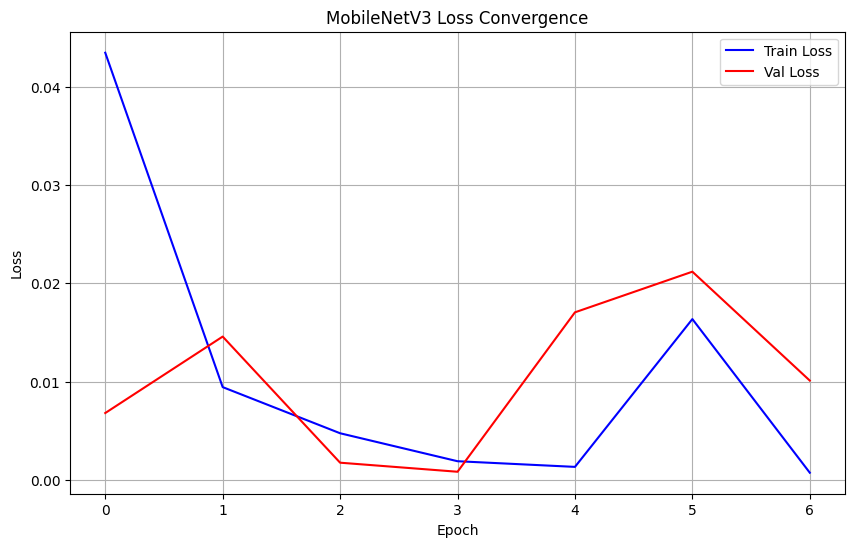

In [54]:
# Train with early stopping
print("\n===== Training MobileNetV3 with Early Stopping =====")
mobile_train_loss, mobile_val_loss, best_model_path = train_model(
    mobilenet_model,
    train_loader,
    val_loader,
    model_name=model_name,
)

# Plot loss convergence
plot_loss(mobile_train_loss, mobile_val_loss, "MobileNetV3 Loss Convergence")

Evaluating the model on the testing set

✅ Model loaded from /content/drive/MyDrive/saved_models_states/mobilenet_best_model.pth and ready for evaluation.


===== MobileNetV3 Evaluation =====


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Evaluation Metrics:
Accuracy : 0.9995
Precision: 0.9987
Recall   : 1.0000
F1 Score : 0.9994

Classification Report:
              precision    recall  f1-score   support

        NRPW       1.00      1.00      1.00      1326
         RPW       1.00      1.00      1.00       774

    accuracy                           1.00      2100
   macro avg       1.00      1.00      1.00      2100
weighted avg       1.00      1.00      1.00      2100



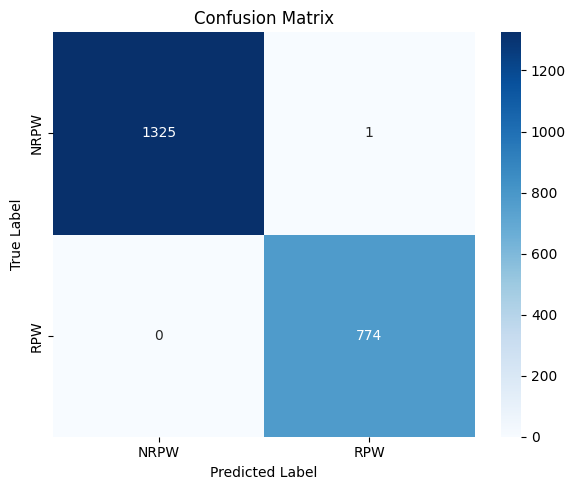

In [45]:
# Load best model for final evaluation
mobilenet_model.load_state_dict(torch.load(best_model_path,map_location=device))
mobilenet_model.eval()
print(f"✅ Model loaded from {best_model_path} and ready for evaluation.\n")

# Evaluate
print("\n===== MobileNetV3 Evaluation =====")
mobile_metrics = evaluate(mobilenet_model, test_loader)

### 2.Train and Evaluate EfficientNetB0

Next, let's train and evaluate the EfficientNetB0 model using the same approach.

In [34]:
# Define model name
model_name = "efficientnet_b0"

# Prepare dataloaders using model-specific image size
train_loader, val_loader, test_loader, class_names = prepare_dataloaders(model_name, batch_size=64)

# Build model
efficientnet_b0_model = build_model(model_name)
print("Using device:", device)
print("Model on device:", next(efficientnet_b0_model.parameters()).device)

Train dataset size: 9800
Validation dataset size: 2100
Test dataset size: 2100
Classes: ['NRPW', 'RPW']
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
Using device: cuda
Model on device: cuda:0


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



===== Training EfficientNetB0 with Early Stopping =====


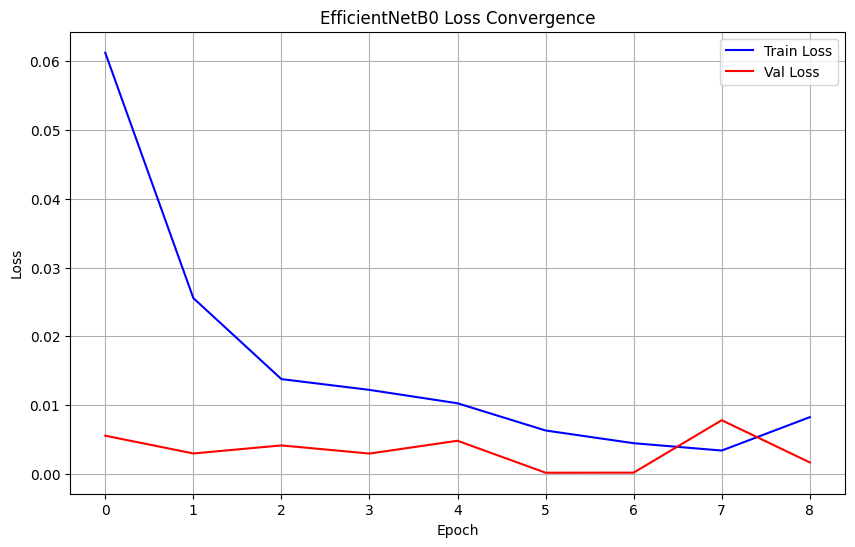

In [53]:
# Train with early stopping
print("\n===== Training EfficientNetB0 with Early Stopping =====")
eff0_train_loss, eff0_val_loss, best_model_path = train_model(
    efficientnet_b0_model,
    train_loader,
    val_loader,
    model_name=model_name,
)

# Plot training/validation loss
plot_loss(eff0_train_loss, eff0_val_loss, "EfficientNetB0 Loss Convergence")

Evaluating the model on the testing set

✅ Model loaded from /content/drive/MyDrive/saved_models_states/efficientnet_b0_best_model.pth and ready for evaluation.


===== EfficientNetB0 Evaluation =====


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Evaluation Metrics:
Accuracy : 0.9990
Precision: 0.9974
Recall   : 1.0000
F1 Score : 0.9987

Classification Report:
              precision    recall  f1-score   support

        NRPW       1.00      1.00      1.00      1326
         RPW       1.00      1.00      1.00       774

    accuracy                           1.00      2100
   macro avg       1.00      1.00      1.00      2100
weighted avg       1.00      1.00      1.00      2100



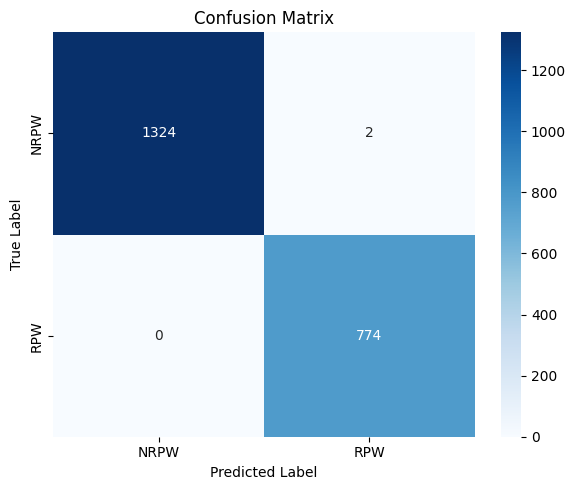

In [48]:
# Load best model after training
efficientnet_b0_model.load_state_dict(torch.load(best_model_path, map_location=device))
efficientnet_b0_model.eval()
print(f"✅ Model loaded from {best_model_path} and ready for evaluation.\n")

# Evaluate on test set
print("\n===== EfficientNetB0 Evaluation =====")
eff0_metrics = evaluate(efficientnet_b0_model, test_loader)

### 2.Train and Evaluate EfficientNetB2

Next, let's train and evaluate the EfficientNetB2 model using the same approach.

In [ ]:
# Define model name
model_name = "efficientnet_b2"

# Prepare dataloaders
train_loader, val_loader, test_loader, class_names = prepare_dataloaders(model_name, batch_size=64)

# Build model
efficientnet_b2_model = build_model(model_name)
print("Using device:", device)
print("Model on device:", next(efficientnet_b2_model.parameters()).device)



===== Training EfficientNetB2 with Early Stopping =====


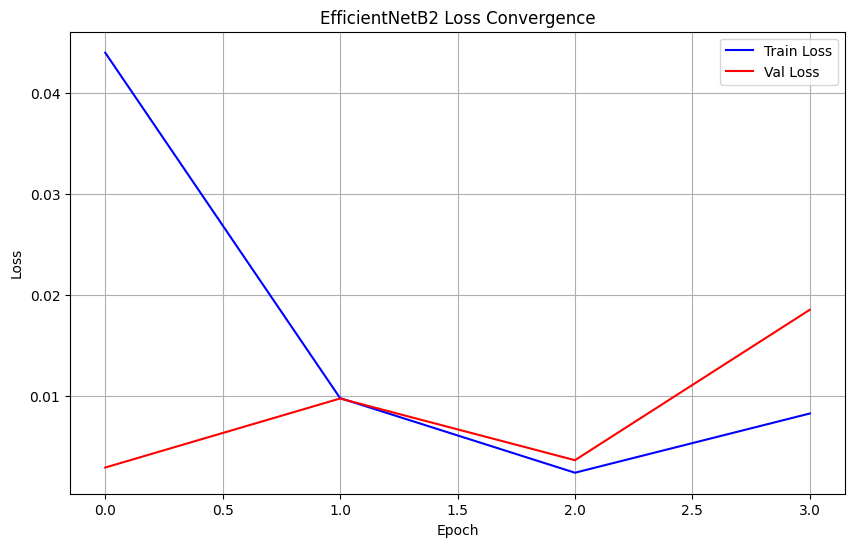

In [52]:
# Train with early stopping
print("\n===== Training EfficientNetB2 with Early Stopping =====")
eff2_train_loss, eff2_val_loss, best_model_path = train_model(
    efficientnet_b2_model,
    train_loader,
    val_loader,
    model_name=model_name,
)

# Plot loss convergence
plot_loss(eff2_train_loss, eff2_val_loss, "EfficientNetB2 Loss Convergence")

Evaluating the model on the testing set

✅ Model loaded from /content/drive/MyDrive/saved_models_states/efficientnet_b2_best_model.pth and ready for evaluation.


===== EfficientNetB2 Evaluation =====


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Evaluation Metrics:
Accuracy : 0.9910
Precision: 0.9760
Recall   : 1.0000
F1 Score : 0.9879

Classification Report:
              precision    recall  f1-score   support

        NRPW       1.00      0.99      0.99      1326
         RPW       0.98      1.00      0.99       774

    accuracy                           0.99      2100
   macro avg       0.99      0.99      0.99      2100
weighted avg       0.99      0.99      0.99      2100



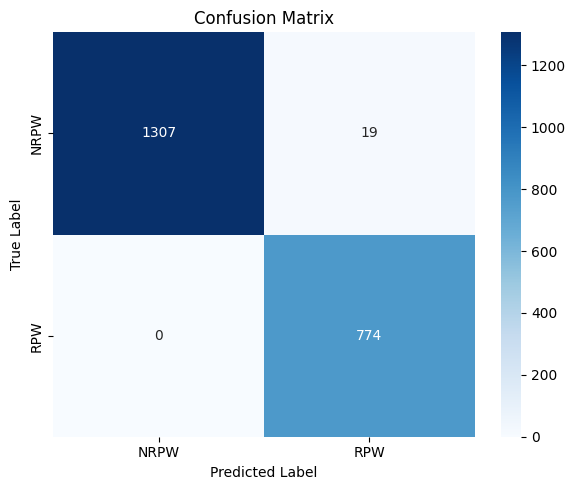

In [51]:
# Load best model
efficientnet_b2_model.load_state_dict(torch.load(best_model_path, map_location=device))
efficientnet_b2_model.eval()
print(f"✅ Model loaded from {best_model_path} and ready for evaluation.\n")

# Evaluate
print("\n===== EfficientNetB2 Evaluation =====")
eff2_metrics = evaluate(efficientnet_b2_model, test_loader)

### 3.Train and Evaluate EfficientNetB3

Next, let's train and evaluate the EfficientNetB3 model using the same approach.

In [65]:
# Define model name
model_name = "efficientnet_b3"

# Prepare dataloaders
train_loader, val_loader, test_loader, class_names = prepare_dataloaders(model_name, batch_size=64)

# Build model
efficientnet_b3_model = build_model(model_name)
print("Using device:", device)
print("Model on device:", next(efficientnet_b3_model.parameters()).device)

Train dataset size: 9800
Validation dataset size: 2100
Test dataset size: 2100
Classes: ['NRPW', 'RPW']
Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1000, bias=True)
)
Using device: cuda
Model on device: cuda:0



===== Training EfficientNetB3 with Early Stopping =====


Epoch 1/10 - Validation: 100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


[Epoch 1] 🔹 Train Loss: 0.0401 🔸 Val Loss: 0.0120
✅ Best model saved at epoch 1 to /content/drive/MyDrive/saved_models_states/efficientnet_b3_best_model.pth


Epoch 2/10 - Validation: 100%|██████████| 33/33 [00:10<00:00,  3.23it/s]


[Epoch 2] 🔹 Train Loss: 0.0052 🔸 Val Loss: 0.0015
✅ Best model saved at epoch 2 to /content/drive/MyDrive/saved_models_states/efficientnet_b3_best_model.pth


Epoch 3/10 - Validation: 100%|██████████| 33/33 [00:10<00:00,  3.12it/s]


[Epoch 3] 🔹 Train Loss: 0.0062 🔸 Val Loss: 0.0014
✅ Best model saved at epoch 3 to /content/drive/MyDrive/saved_models_states/efficientnet_b3_best_model.pth


Epoch 4/10 - Validation: 100%|██████████| 33/33 [00:10<00:00,  3.01it/s]


[Epoch 4] 🔹 Train Loss: 0.0064 🔸 Val Loss: 0.0107
⏳ No improvement for 1 epoch(s).


Epoch 5/10 - Validation: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s]


[Epoch 5] 🔹 Train Loss: 0.0049 🔸 Val Loss: 0.0065
⏳ No improvement for 2 epoch(s).


Epoch 6/10 - Validation: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s]


[Epoch 6] 🔹 Train Loss: 0.0045 🔸 Val Loss: 0.0086
⏳ No improvement for 3 epoch(s).
⛔ Early stopping triggered after 6 epochs.


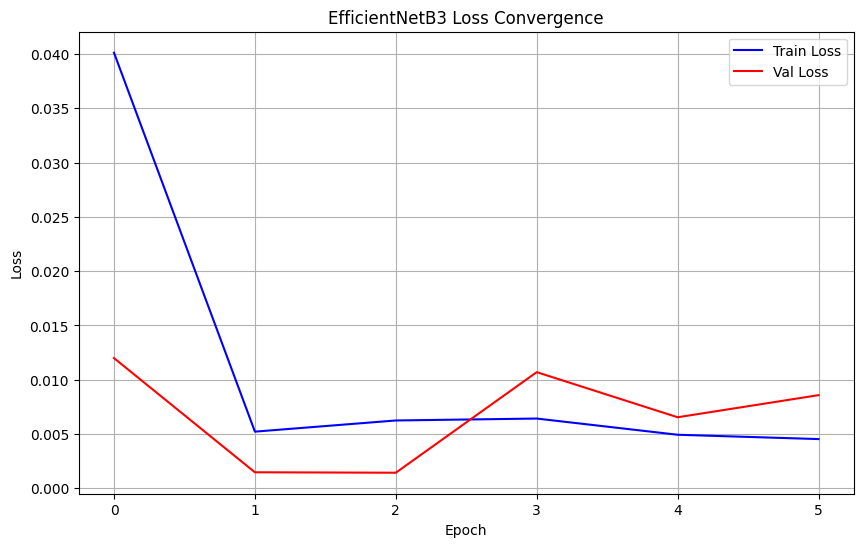

In [66]:
# Train with early stopping
print("\n===== Training EfficientNetB3 with Early Stopping =====")
eff3_train_loss, eff3_val_loss, best_model_path = train_model(
    efficientnet_b3_model,
    train_loader,
    val_loader,
    model_name=model_name,
)

# Plot loss convergence
plot_loss(eff3_train_loss, eff3_val_loss, "EfficientNetB3 Loss Convergence")

Evaluating the model on the testing set

In [67]:
# Load best model
efficientnet_b3_model.load_state_dict(torch.load(best_model_path))
efficientnet_b3_model.eval()
print(f"✅ Model loaded from {best_model_path} and ready for evaluation.\n")

# Evaluate
print("\n===== EfficientNetB3 Evaluation =====")
eff3_metrics = evaluate(efficientnet_b3_model, test_loader)

✅ Model loaded from /content/drive/MyDrive/saved_models_states/efficientnet_b3_best_model.pth and ready for evaluation.


===== EfficientNetB3 Evaluation =====

Evaluation Metrics:
Accuracy : 0.9995
Precision: 0.9987
Recall   : 1.0000
F1 Score : 0.9994

Classification Report:
              precision    recall  f1-score   support

        NRPW       1.00      1.00      1.00      1326
         RPW       1.00      1.00      1.00       774

    accuracy                           1.00      2100
   macro avg       1.00      1.00      1.00      2100
weighted avg       1.00      1.00      1.00      2100



### 4.Train and Evaluate EfficientNetB4

Next, let's train and evaluate the EfficientNetB4 model using the same approach.

In [68]:
# Define model name
model_name = "efficientnet_b4"

# Prepare dataloaders using model-specific image size
train_loader, val_loader, test_loader, class_names = prepare_dataloaders(model_name, batch_size=64)

# Build model
efficientnet_b4_model = build_model(model_name)
print("Using device:", device)
print("Model on device:", next(efficientnet_b4_model.parameters()).device)


Train dataset size: 9800
Validation dataset size: 2100
Test dataset size: 2100
Classes: ['NRPW', 'RPW']
Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1792, out_features=1000, bias=True)
)
Using device: cuda
Model on device: cuda:0



===== Training EfficientNetB4 with Early Stopping =====


Epoch 1/10 - Validation: 100%|██████████| 33/33 [00:16<00:00,  2.04it/s]


[Epoch 1] 🔹 Train Loss: 0.0437 🔸 Val Loss: 0.0003
✅ Best model saved at epoch 1 to /content/drive/MyDrive/saved_models_states/efficientnet_b4_best_model.pth


Epoch 2/10 - Validation: 100%|██████████| 33/33 [00:17<00:00,  1.93it/s]


[Epoch 2] 🔹 Train Loss: 0.0056 🔸 Val Loss: nan
⏳ No improvement for 1 epoch(s).


Epoch 3/10 - Validation: 100%|██████████| 33/33 [00:16<00:00,  1.99it/s]


[Epoch 3] 🔹 Train Loss: 0.0072 🔸 Val Loss: 0.0001
✅ Best model saved at epoch 3 to /content/drive/MyDrive/saved_models_states/efficientnet_b4_best_model.pth


Epoch 4/10 - Validation: 100%|██████████| 33/33 [00:15<00:00,  2.07it/s]


[Epoch 4] 🔹 Train Loss: 0.0007 🔸 Val Loss: 0.0036
⏳ No improvement for 1 epoch(s).


Epoch 5/10 - Validation: 100%|██████████| 33/33 [00:16<00:00,  2.01it/s]


[Epoch 5] 🔹 Train Loss: 0.0011 🔸 Val Loss: nan
⏳ No improvement for 2 epoch(s).


Epoch 6/10 - Validation: 100%|██████████| 33/33 [00:16<00:00,  2.01it/s]


[Epoch 6] 🔹 Train Loss: 0.0025 🔸 Val Loss: 0.0000
✅ Best model saved at epoch 6 to /content/drive/MyDrive/saved_models_states/efficientnet_b4_best_model.pth


Epoch 7/10 - Validation: 100%|██████████| 33/33 [00:17<00:00,  1.93it/s]


[Epoch 7] 🔹 Train Loss: 0.0010 🔸 Val Loss: 0.0042
⏳ No improvement for 1 epoch(s).


Epoch 8/10 - Validation: 100%|██████████| 33/33 [00:16<00:00,  2.00it/s]


[Epoch 8] 🔹 Train Loss: 0.0017 🔸 Val Loss: 0.0000
✅ Best model saved at epoch 8 to /content/drive/MyDrive/saved_models_states/efficientnet_b4_best_model.pth


Epoch 9/10 - Validation: 100%|██████████| 33/33 [00:16<00:00,  2.03it/s]


[Epoch 9] 🔹 Train Loss: 0.0007 🔸 Val Loss: 0.0000
⏳ No improvement for 1 epoch(s).


Epoch 10/10 - Validation: 100%|██████████| 33/33 [00:16<00:00,  1.99it/s]

[Epoch 10] 🔹 Train Loss: 0.0016 🔸 Val Loss: 0.0015
⏳ No improvement for 2 epoch(s).


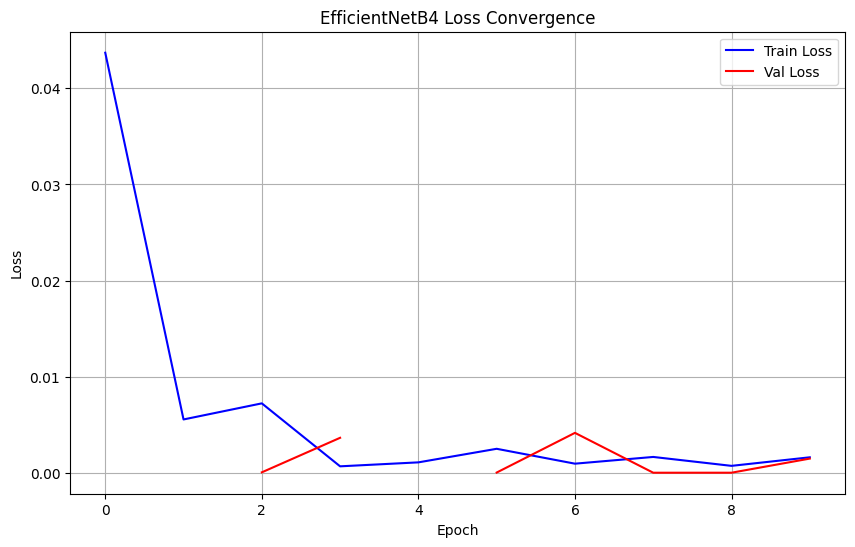

In [69]:
# Train with early stopping
print("\n===== Training EfficientNetB4 with Early Stopping =====")
eff4_train_loss, eff4_val_loss, best_model_path = train_model(
    efficientnet_b4_model,
    train_loader,
    val_loader,
    model_name=model_name,
)

# Plot training/validation loss
plot_loss(eff4_train_loss, eff4_val_loss, "EfficientNetB4 Loss Convergence")

✅ Model loaded from /content/drive/MyDrive/saved_models_states/efficientnet_b4_best_model.pth and ready for evaluation.


===== EfficientNetB4 Evaluation =====

Evaluation Metrics:
Accuracy : 0.9990
Precision: 1.0000
Recall   : 0.9974
F1 Score : 0.9987

Classification Report:
              precision    recall  f1-score   support

        NRPW       1.00      1.00      1.00      1326
         RPW       1.00      1.00      1.00       774

    accuracy                           1.00      2100
   macro avg       1.00      1.00      1.00      2100
weighted avg       1.00      1.00      1.00      2100



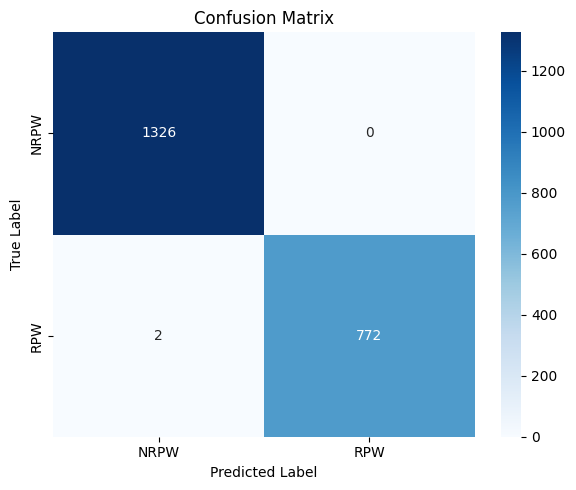

In [70]:
# Load best model after training
efficientnet_b4_model.load_state_dict(torch.load(best_model_path))
efficientnet_b4_model.eval()
print(f"✅ Model loaded from {best_model_path} and ready for evaluation.\n")

# Evaluate on test set
print("\n===== EfficientNetB4 Evaluation =====")
eff4_metrics = evaluate(efficientnet_b4_model, test_loader)

## 6- Model Comparison

Finally, let's compare the performance of both models side by side.

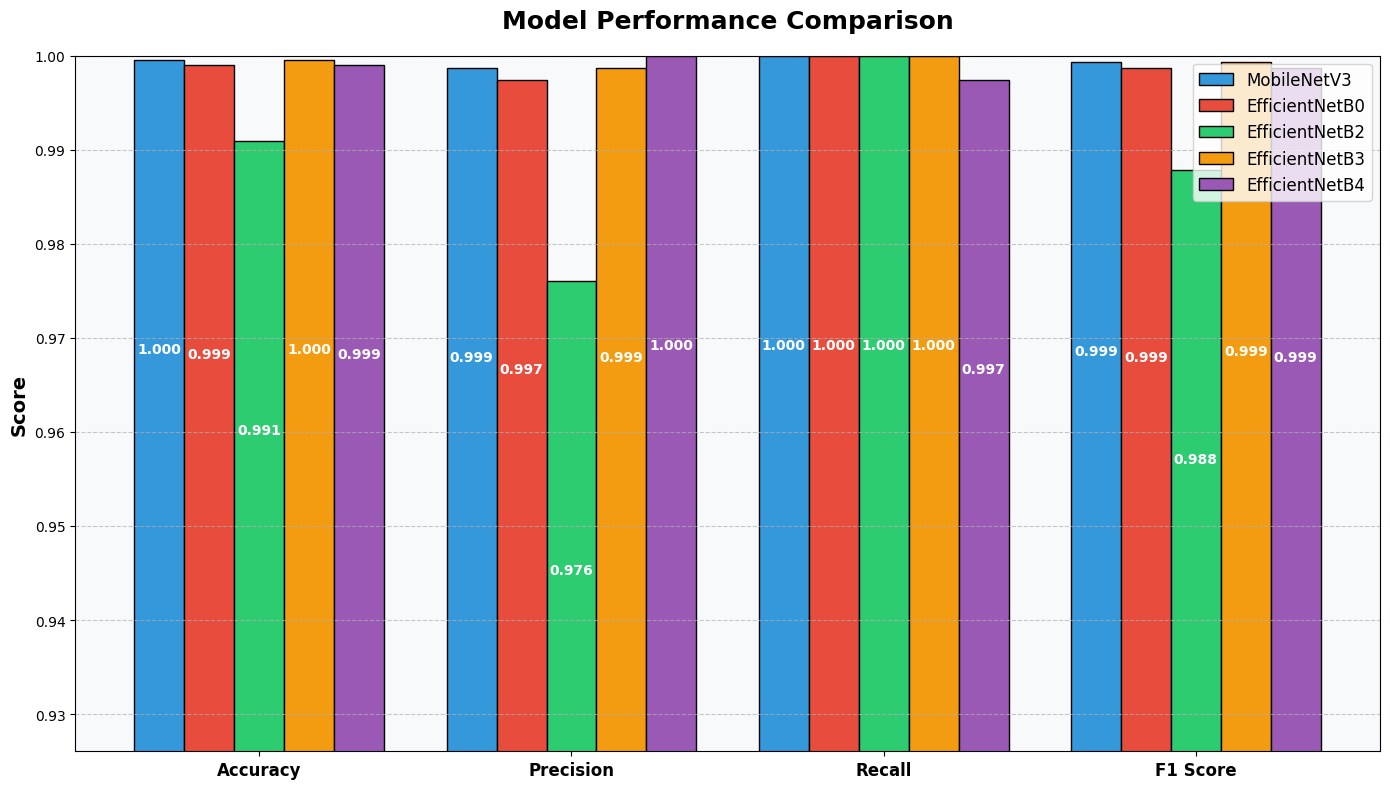

In [71]:
# Step 2: Organize metrics into a dictionary
model_metrics = {
    "MobileNetV3": list(mobile_metrics),
    "EfficientNetB0": list(eff0_metrics),
    "EfficientNetB2": list(eff2_metrics),
    "EfficientNetB3": list(eff3_metrics),
    "EfficientNetB4": list(eff4_metrics),
}


# Step 3: Define plotting function
def plot_model_comparison(model_metrics):
    import numpy as np
    import matplotlib.pyplot as plt

    metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
    models = list(model_metrics.keys())
    values = [model_metrics[m] for m in models]

    num_metrics = len(metrics_names)
    num_models = len(models)
    x = np.arange(num_metrics)
    width = 0.8 / num_models  # Keep bars within group

    plt.figure(figsize=(14, 8))

    # Custom color palette
    colors = ["#3498db", "#e74c3c", "#2ecc71", "#f39c12", "#9b59b6", "#1abc9c"]

    # Plot each model's bars
    for i, (model_name, scores) in enumerate(model_metrics.items()):
        offset = (i - num_models / 2) * width + width / 2
        plt.bar(
            x + offset,
            scores,
            width,
            label=model_name,
            color=colors[i % len(colors)],
            edgecolor="black",
            linewidth=1,
        )

        # Add value labels
        for j, score in enumerate(scores):
            plt.text(
                x[j] + offset,
                score - 0.03,
                f"{score:.3f}",
                ha="center",
                va="top",
                fontsize=10,
                fontweight="bold",
                color="white",
            )

    # Styling
    plt.xticks(x, metrics_names, fontsize=12, fontweight="bold")
    plt.ylabel("Score", fontsize=14, fontweight="bold")
    plt.title("Model Performance Comparison", fontsize=18, fontweight="bold", pad=20)
    plt.legend(fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.ylim(max(0, min(min(v) for v in values) - 0.05), 1.0)
    plt.gca().set_facecolor("#f8f9fa")
    plt.tight_layout()
    plt.show()


# Step 4: Plot all together
plot_model_comparison(model_metrics)

In [73]:
# Step 1: Organize loss metrics into a dictionary
loss_metrics = {
    "MobileNetV3": {"train": mobile_train_loss, "val": mobile_val_loss},
    "EfficientNetB0": {"train": eff0_train_loss, "val": eff0_val_loss},
    "EfficientNetB2": {"train": eff2_train_loss, "val": eff2_val_loss},
    "EfficientNetB3": {"train": eff3_train_loss, "val": eff3_val_loss},
    "EfficientNetB4": {"train": eff4_train_loss, "val": eff4_val_loss},
}

# Function to plot training loss
def plot_training_loss(loss_metrics):
    plt.figure(figsize=(12, 6))

    # Custom color palette for the models
    colors = {
        "MobileNetV3": "#3498db",
        "EfficientNetB0": "#e74c3c",
        "EfficientNetB2": "#2ecc71",
        "EfficientNetB3": "#f39c12",
        "EfficientNetB4": "#9b59b6",
    }

    # Plot each model's training loss
    for model_name, losses in loss_metrics.items():
        epochs = range(len(losses["train"]))

        plt.plot(
            epochs,
            losses["train"],
            label=f"{model_name} Train",
            color=colors.get(model_name, '#000000'),
            linewidth=2.5,
            marker='o',
            markersize=6
        )

    # Styling for the plot
    plt.title("Training Loss Comparison", fontsize=18, fontweight='bold', pad=15)
    plt.xlabel("Epoch", fontsize=14, fontweight='bold')
    plt.ylabel("Loss", fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12, frameon=True, facecolor='white', framealpha=1, edgecolor='gray', loc='upper right')
    plt.tight_layout()
    plt.show()

# Function to plot validation loss
def plot_validation_loss(loss_metrics):
    plt.figure(figsize=(12, 6))

    # Custom color palette for the models
    colors = {
        "MobileNetV3": "#3498db",
        "EfficientNetB0": "#e74c3c",
        "EfficientNetB2": "#2ecc71",
        "EfficientNetB3": "#f39c12",
        "EfficientNetB4": "#9b59b6",
    }

    # Plot each model's validation loss
    for model_name, losses in loss_metrics.items():
        epochs = range(len(losses["val"]))

        plt.plot(
            epochs,
            losses["val"],
            label=f"{model_name} Val",
            color=colors.get(model_name, '#000000'),
            linewidth=2.5,
            linestyle='--',
            marker='o',
            markersize=6
        )

    # Styling for the plot
    plt.title("Validation Loss Comparison", fontsize=18, fontweight='bold', pad=15)
    plt.xlabel("Epoch", fontsize=14, fontweight='bold')
    plt.ylabel("Loss", fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12, frameon=True, facecolor='white', framealpha=1, edgecolor='gray', loc='upper right')
    plt.tight_layout()
    plt.show()



**Comparing the Training loss of the models**

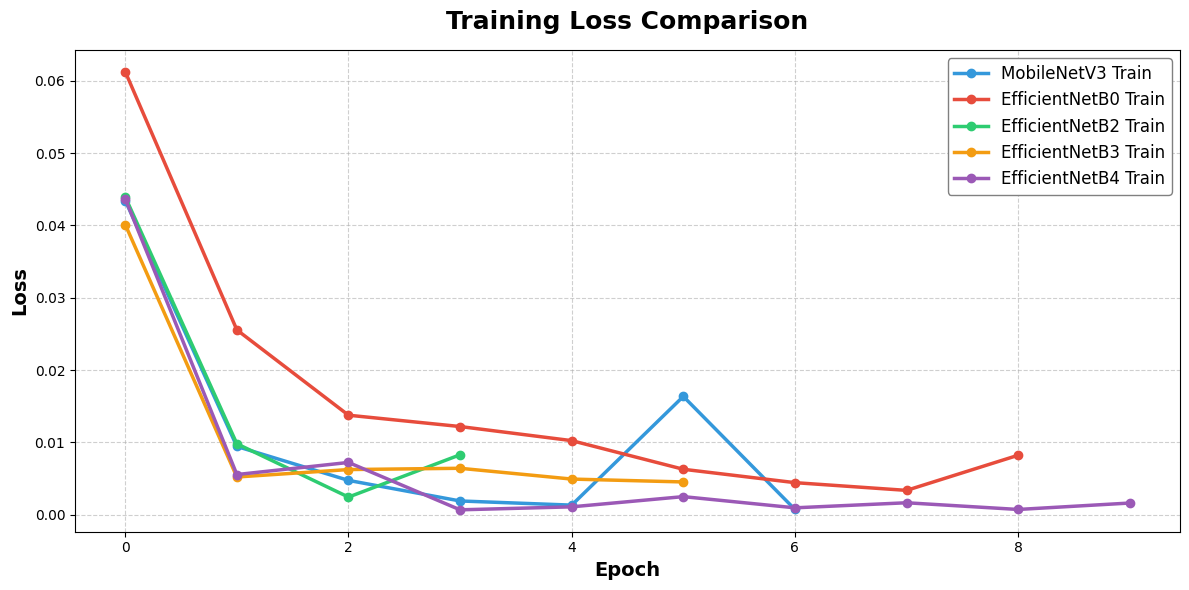

In [74]:
plot_training_loss(loss_metrics)

**Comparing the Validation loss of the models**

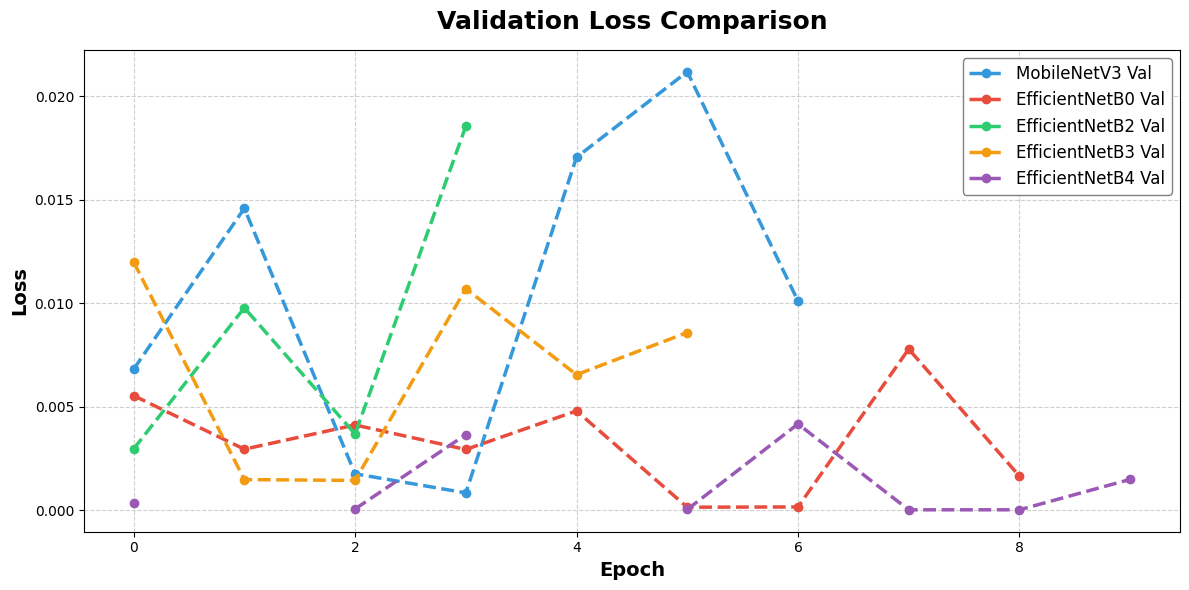

In [75]:
plot_validation_loss(loss_metrics)


## Save Models

Let's save our trained models for future use.

In [76]:
# Create directory in Google Drive to store the full models
save_dir = '/content/drive/MyDrive/full_models'
os.makedirs(save_dir, exist_ok=True)

# Save model state_dicts
torch.save(mobilenet_model, f'{save_dir}/mobilenetv3_rpw.pth')
torch.save(efficientnet_b0_model, f'{save_dir}/efficientnet_b0_rpw.pth')
torch.save(efficientnet_b2_model, f'{save_dir}/efficientnet_b2_rpw.pth')
torch.save(efficientnet_b3_model, f'{save_dir}/efficientnet_b3_rpw.pth')
torch.save(efficientnet_b4_model, f'{save_dir}/efficientnet_b4_rpw.pth')

print("All models have been saved to Google Drive successfully!")

All models have been saved to Google Drive successfully!


## Conclusion

In this notebook, we've compared multiple models on a custom dataset. Key takeaways:

1. Models are optimized for mobile/edge devices but have different trade-offs
2. MobileNetV3 typically has faster inference but may sacrifice some accuracy
3. EfficientNet models often achieves higher accuracy but with increased computational cost
4. The in-memory dataset approach works well for smaller datasets but may not be suitable for larger ones
5. Partial freezing of layers helps leverage pre-trained weights while adapting to our specific task

For real-world deployment, consider:
- Model quantization for further optimization
- More sophisticated data augmentation techniques
- Hyperparameter tuning (learning rate, batch size, etc.)
- Ensemble methods for potentially higher accuracy